# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

c:\users\shiva_kv\appdata\local\programs\python\python37\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 'Negative'
    return 'Positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(393933, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.29901100176971

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(393931, 10)


Positive    336824
Negative     57107
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

In June<br />I saw a charming group<br />of roses all begin<br />to droop<br />I pepped them up<br />with chicken soup!<br />Sprinkle once<br />sprinkle twice<br />sprinkle chicken soup<br />with rice<br /><br />This is a great book to teach children the months of the year. The repetition of the phrases and the funny little stories with accompanying pictures make for an ideal bedtime read. This isn't nearly as good as some of Sendak's other books (like Where the Wild Things are or Pierre: The Boy Who Didn't Care), but it still carries his unique brand of charm.
Its a great snack for icecream lovers who have teeth sensitve to cold.<br />All the flavor u want and no mater how much or fast u eat no brain frezze.<br />I found it best when its cold out side i can still have my icecream and not fell like im frezzing.<br />Its a great value price /per product. And has a long shelf life making it a good survival snack.
My cat loves these bubbles. All I have to say is "Do you want bubbles?" and

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

In June<br />I saw a charming group<br />of roses all begin<br />to droop<br />I pepped them up<br />with chicken soup!<br />Sprinkle once<br />sprinkle twice<br />sprinkle chicken soup<br />with rice<br /><br />This is a great book to teach children the months of the year. The repetition of the phrases and the funny little stories with accompanying pictures make for an ideal bedtime read. This isn't nearly as good as some of Sendak's other books (like Where the Wild Things are or Pierre: The Boy Who Didn't Care), but it still carries his unique brand of charm.


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

In JuneI saw a charming groupof roses all beginto droopI pepped them upwith chicken soup!Sprinkle oncesprinkle twicesprinkle chicken soupwith riceThis is a great book to teach children the months of the year. The repetition of the phrases and the funny little stories with accompanying pictures make for an ideal bedtime read. This isn't nearly as good as some of Sendak's other books (like Where the Wild Things are or Pierre: The Boy Who Didn't Care), but it still carries his unique brand of charm.
Its a great snack for icecream lovers who have teeth sensitve to cold.All the flavor u want and no mater how much or fast u eat no brain frezze.I found it best when its cold out side i can still have my icecream and not fell like im frezzing.Its a great value price /per product. And has a long shelf life making it a good survival snack.
My cat loves these bubbles. All I have to say is "Do you want bubbles?" and she comes running out from wherever she may be hiding. She meows and pounces on the

In [18]:
def clean_html(sentence): #function to clean the word of html-tags
    clean = re.compile('<.*?>')
    clean_text = clean.sub('',sentence)
    return clean_text
def clean_punc(sentence): #function to clean the word pf any punctuation or special characters
    cleaned = re.compile(r'[?|!|\'|"|#|:|-|.|,|)|(|\\|/|~|%|*]')
    cleaned_punc = cleaned.sub('',sentence)
    return cleaned_punc

In [19]:
cl = clean_html(sent_0)
print(cl)
print(100 * "=")
print(clean_punc(cl))

In JuneI saw a charming groupof roses all beginto droopI pepped them upwith chicken soup!Sprinkle oncesprinkle twicesprinkle chicken soupwith riceThis is a great book to teach children the months of the year. The repetition of the phrases and the funny little stories with accompanying pictures make for an ideal bedtime read. This isn't nearly as good as some of Sendak's other books (like Where the Wild Things are or Pierre: The Boy Who Didn't Care), but it still carries his unique brand of charm.
In JuneI saw a charming groupof roses all beginto droopI pepped them upwith chicken soupSprinkle oncesprinkle twicesprinkle chicken soupwith riceThis is a great book to teach children the months of the year The repetition of the phrases and the funny little stories with accompanying pictures make for an ideal bedtime read This isnt nearly as good as some of Sendaks other books like Where the Wild Things are or Pierre The Boy Who Didnt Care but it still carries his unique brand of charm


In [22]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [23]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

My cat loves these bubbles. All I have to say is "Do you want bubbles?" and she comes running out from wherever she may be hiding. She meows and pounces on the bubbles. I am giving them a rating of 4 though because they smell horrible. If they drip on anything white it will turn green, but can easily be cleaned with some water and a sponge!!!!


In [24]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

In June<br />I saw a charming group<br />of roses all begin<br />to droop<br />I pepped them up<br />with chicken soup!<br />Sprinkle once<br />sprinkle twice<br />sprinkle chicken soup<br />with rice<br /><br />This is a great book to teach children the months of the year. The repetition of the phrases and the funny little stories with accompanying pictures make for an ideal bedtime read. This isn't nearly as good as some of Sendak's other books (like Where the Wild Things are or Pierre: The Boy Who Didn't Care), but it still carries his unique brand of charm.


In [25]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

My cat loves these bubbles All I have to say is Do you want bubbles and she comes running out from wherever she may be hiding She meows and pounces on the bubbles I am giving them a rating of 4 though because they smell horrible If they drip on anything white it will turn green but can easily be cleaned with some water and a sponge 


In [26]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stop = set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [27]:
%%time
from nltk.stem import SnowballStemmer
snow = SnowballStemmer('english')
str1 = ' '
s=''
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
i=0
for i, sent in enumerate(tqdm(final['Text'].values)):
    filtered_sentence=[]
    #print(sent);
    sent = BeautifulSoup(sent, 'lxml').get_text()
    sent = decontracted(sent)
    sent = clean_html(sent) # remove HTMl tags
    for w in sent.split():
        # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
        # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
        #print(sent.split())
        for cleaned_words in clean_punc(w).split():
           # print("================================>",cleaned_words)
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(snow.stem(cleaned_words.lower())).encode('utf8')
                       # print("Selected: Stem Word->",s)
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 'Positive':
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if (final['Score'].values)[i] == 'Negative':
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    else:
                        #print("Eliminated as it is a stopword")
                        continue
            else:
                #print("Eliminated as it is a numerical value or character of lenght less than 2")
                continue
           # print(filtered_sentence)

    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    final_string.append(str1)
    #print(final_string)
    i+=1
final['Cleaned_Text']=final_string
print("Processing completed in")

100%|█████████████████████████████████████████████████████████████████████████| 393931/393931 [07:14<00:00, 905.88it/s]


Processing completed in
Wall time: 7min 15s


In [28]:
from collections import Counter
print("No.of Positive words::",len(all_positive_words))
print("No.of Negative words::",len(all_negative_words))
print("Sample word from positive words::",all_positive_words[0:20])
print("Sample word from negative words::",all_negative_words[0:20])
positive_words = Counter(all_positive_words)
print("\nMost Common positive words",positive_words.most_common(10))
negative_words = Counter(all_negative_words)
print("\nMost Common negative words",negative_words.most_common(10))

No.of Positive words:: 13009917
No.of Negative words:: 2387956
Sample word from positive words:: [b'junei', b'saw', b'charm', b'groupof', b'rose', b'beginto', b'droopi', b'pep', b'upwith', b'chicken', b'soupsprinkl', b'oncesprinkl', b'twicesprinkl', b'chicken', b'soupwith', b'ricethi', b'great', b'book', b'teach', b'children']
Sample word from negative words:: [b'give', b'five', b'star', b'mauric', b'sendak', b'stori', b'one', b'star', b'print', b'edit', b'bookmi', b'children', b'older', b'copi', b'book', b'familiar', b'previous', b'softcov', b'version', b'order']

Most Common positive words [(b'not', 339960), (b'like', 159014), (b'tast', 145667), (b'good', 122861), (b'flavor', 121961), (b'use', 113317), (b'love', 112293), (b'great', 106316), (b'one', 105336), (b'product', 100471)]

Most Common negative words [(b'not', 92681), (b'tast', 33839), (b'like', 32057), (b'product', 27445), (b'would', 23207), (b'one', 20179), (b'flavor', 18927), (b'tri', 17520), (b'use', 15155), (b'good', 1463

In [29]:
%%time
from nltk.stem import SnowballStemmer
snow = SnowballStemmer('english')
str1 = ' '
s=''
final_string_nostem=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
i=0
for i, sent in enumerate(tqdm(final['Text'].values)):
    filtered_sentence=[]
    #print(sent);
    sent = BeautifulSoup(sent, 'lxml').get_text()
    sent = decontracted(sent)
    sent = clean_html(sent) # remove HTMl tags
    for w in sent.split():
        # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
        # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
        #print(sent.split())
        for cleaned_words in clean_punc(w).split():
           # print("================================>",cleaned_words)
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=cleaned_words.lower().encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 'Positive':
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if (final['Score'].values)[i] == 'Negative':
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    else:
                        #print("Eliminated as it is a stopword")
                        continue
            else:
                #print("Eliminated as it is a numerical value or character of lenght less than 2")
                continue
           # print(filtered_sentence)

    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    final_string_nostem.append(str1)
    #print(final_string)
    i+=1
final['Cleaned_Text_nostem']=final_string_nostem
print("Processing completed in")

100%|████████████████████████████████████████████████████████████████████████| 393931/393931 [03:27<00:00, 1895.16it/s]


Processing completed in
Wall time: 3min 28s


In [30]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text,Cleaned_Text_nostem
150528,150529,0006641040,A25ACLV5KPB4W,"Matt Hetling ""Matt""",0,1,Positive,1108425600,"Nice cadence, catchy rhymes",In June<br />I saw a charming group<br />of ro...,b'junei saw charm groupof rose beginto droopi ...,b'junei saw charming groupof roses beginto dro...
150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,Positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...,b'fun way children learn months year learn poe...
150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,Positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...,b'grew reading sendak books watching really ro...
150504,150505,0006641040,A2PTSM496CF40Z,"Jason A. Teeple ""Nobody made a greater mistak...",1,1,Positive,1210809600,A classic,Get the movie or sound track and sing along wi...,b'get movi sound track sing along carol king g...,b'get movie sound track sing along carol king ...
150503,150504,0006641040,AQEYF1AXARWJZ,"Les Sinclair ""book maven""",1,1,Positive,1212278400,Chicken Soup with Rice,A very entertaining rhyming story--cleaver and...,b'entertain rhyme catchyth illustr imagin fit ...,b'entertaining rhyming catchythe illustrations...


In [31]:
# Saving preprocessed reviews into sql DB
import sqlite3 # importing sqlite3

# Creating final_reviews.sqlite file to store preprocessed reviews
con = sqlite3.connect('final_reviews.sqlite') 
con.text_factory = str
final.to_sql('Reviews', con, if_exists='replace')

In [32]:
# connecting to final_reviews.sqlite
con = sqlite3.connect("final_reviews.sqlite")

final = pd.read_sql_query("""SELECT * FROM Reviews """, con)
final.head(5)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text,Cleaned_Text_nostem
0,150528,150529,0006641040,A25ACLV5KPB4W,"Matt Hetling ""Matt""",0,1,Positive,1108425600,"Nice cadence, catchy rhymes",In June<br />I saw a charming group<br />of ro...,b'junei saw charm groupof rose beginto droopi ...,b'junei saw charming groupof roses beginto dro...
1,150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,Positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...,b'fun way children learn months year learn poe...
2,150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,Positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...,b'grew reading sendak books watching really ro...
3,150504,150505,0006641040,A2PTSM496CF40Z,"Jason A. Teeple ""Nobody made a greater mistak...",1,1,Positive,1210809600,A classic,Get the movie or sound track and sing along wi...,b'get movi sound track sing along carol king g...,b'get movie sound track sing along carol king ...
4,150503,150504,0006641040,AQEYF1AXARWJZ,"Les Sinclair ""book maven""",1,1,Positive,1212278400,Chicken Soup with Rice,A very entertaining rhyming story--cleaver and...,b'entertain rhyme catchyth illustr imagin fit ...,b'entertaining rhyming catchythe illustrations...


In [33]:
final.shape

(393931, 13)

In [34]:
def polarity(x):
    if x == "Positive":
        return 0
    else:
        return 1
final["Score"] = final["Score"].map(polarity)

In [35]:
# Taking 100000 reviews for analysis
n_samples = 100000
final_sample = final.sample(n_samples)

final_sample.head(5)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text,Cleaned_Text_nostem
205912,449276,449277,B001F1SAO6,A30LRW7D32ENR6,Josie,0,0,0,1337299200,Love this flavor!,This is an awesome alternative to coffee. I LO...,b'awesom altern coffe love coffe current cut d...,b'awesome alternative coffee love coffee curre...
96488,163952,163953,B000JMAVPS,A1LK3VZ7AXZ52C,MightyFavog,1,1,0,1208736000,Very Good - and very spicy!,"While I am not Indian, I do cook Indian food f...",b'not indian cook indian food scratch quit oft...,b'not indian cook indian food scratch quite of...
183553,245857,245858,B001E5E3EO,A3OI5EP7O0FFGN,E. Gomez,4,5,0,1174003200,Erewhon Corn Flakes,You can't compare these organic corn flakes to...,b'not compar organ corn flake gmo version find...,b'not compare organic corn flakes gmo version ...
331041,189330,189331,B004DKQNMC,A1QSU0KYYI0OEB,Kenneth S. Wiggins,0,0,0,1349568000,good coffee,There's so much bad coffee in fancy packs. The...,b'much bad coffe fanci pack packag good enough...,b'much bad coffee fancy packs package good eno...
28873,456718,456719,B0009ETA6W,A34V9OZ3I80QHF,"M. Varahram ""annattasiaaa""",0,0,0,1304294400,BE CAREFUL,I took the pill (3x3)two days only but had to ...,b'took pill day stop babi start runni stool li...,b'took pill days stop baby started runny stool...


In [36]:
# Save to file
pickle.dump(final_sample,open("sample_100000_knn.pkl","wb"))

# Load from file
sample = pickle.load(open("sample_100000_knn.pkl","rb"))

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [37]:
## Similartly you can do preprocessing for review summary also.
## Similartly you can do preprocessing for review summary also.
# printing some random reviews
sent_500 = final['Summary'].values[500]
print(sent_500)
print("="*50)

sent_1000 = final['Summary'].values[1000]
print(sent_1000)
print("="*50)

sent_2000 = final['Summary'].values[2000]
print(sent_2000)
print("="*50)

sent_3000 = final['Summary'].values[3000]
print(sent_3000)
print("="*50)

sent_6000 = final['Summary'].values[6000]
print(sent_6000)
print("="*50)

sent_8000 = final['Summary'].values[8000]
print(sent_8000)
print("="*50)


Yep, it kills golphers
Long time favorite
Very pleased, dogs love the food
Hard to find filter for only coffe pot that keeps working
THE BEST DRINK EVER!!
Soups on basket


In [38]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_2000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_3000, 'lxml')
text = soup.get_text()
print(text)

In JuneI saw a charming groupof roses all beginto droopI pepped them upwith chicken soup!Sprinkle oncesprinkle twicesprinkle chicken soupwith riceThis is a great book to teach children the months of the year. The repetition of the phrases and the funny little stories with accompanying pictures make for an ideal bedtime read. This isn't nearly as good as some of Sendak's other books (like Where the Wild Things are or Pierre: The Boy Who Didn't Care), but it still carries his unique brand of charm.
Long time favorite
Very pleased, dogs love the food
Hard to find filter for only coffe pot that keeps working


In [39]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'S", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [40]:
sent_500 = decontracted(sent_500)
print(sent_500)
print("="*50)

Yep, it kills golphers


In [41]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_500 = re.sub('[^A-Za-z0-9]+', ' ', sent_500)
print(sent_500)
print('-'*50)

sent_1000 = re.sub('[^A-Za-z0-9]+', ' ', sent_1000)
print(sent_1000)
print('-'*50)

sent_2000 = re.sub('[^A-Za-z0-9]+', ' ', sent_2000)
print(sent_2000)
print('-'*50)

sent_3000 = re.sub('[^A-Za-z0-9]+', ' ', sent_3000)
print(sent_3000)
print('-'*50)

sent_6000 = re.sub('[^A-Za-z0-9]+', ' ', sent_6000)
print(sent_6000)
print('-'*50)

sent_8000 = re.sub('[^A-Za-z0-9]+', ' ', sent_8000)
print(sent_8000)
print('-'*50)

Yep it kills golphers
--------------------------------------------------
Long time favorite
--------------------------------------------------
Very pleased dogs love the food
--------------------------------------------------
Hard to find filter for only coffe pot that keeps working
--------------------------------------------------
THE BEST DRINK EVER 
--------------------------------------------------
Soups on basket
--------------------------------------------------


In [42]:
%%time
from nltk.stem import SnowballStemmer
snow = SnowballStemmer('english')
str1 = ' '
s=''
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
i=0
for i, sent in enumerate(tqdm(final['Summary'].values)):
    filtered_sentence=[]
    #print(sent);
    sent = BeautifulSoup(sent, 'lxml').get_text()
    sent = decontracted(sent)
    sent = clean_html(sent) # remove HTMl tags
    for w in sent.split():
        # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
        # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
        #print(sent.split())
        for cleaned_words in clean_punc(w).split():
           # print("================================>",cleaned_words)
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(snow.stem(cleaned_words.lower())).encode('utf8')
                       # print("Selected: Stem Word->",s)
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 'Positive':
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if (final['Score'].values)[i] == 'Negative':
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    else:
                        #print("Eliminated as it is a stopword")
                        continue
            else:
                #print("Eliminated as it is a numerical value or character of lenght less than 2")
                continue
           # print(filtered_sentence)

    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    final_string.append(str1)
    #print(final_string)
    i+=1
final['Cleaned_Summary']=final_string
print("Processing completed in")

  0%|                                                                           | 237/393931 [00:00<02:58, 2211.15it/s]c:\users\shiva_kv\appdata\local\programs\python\python37\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
  6%|████▍                                                                    | 23898/393931 [00:07<01:59, 3103.52it/s]c:\users\shiva_kv\appdata\local\programs\python\python37\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 10%|███████                                                                  | 38270/393931 [00:12<01:52, 3169.84it/s]c:\users\shiva_kv\appdata\local\programs\python\python37\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'...'"

 90%|█████████████████████████████████████████████████████████████████       | 355835/393931 [01:54<00:12, 3119.37it/s]c:\users\shiva_kv\appdata\local\programs\python\python37\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 92%|██████████████████████████████████████████████████████████████████▏     | 361942/393931 [01:56<00:10, 3063.13it/s]c:\users\shiva_kv\appdata\local\programs\python\python37\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 96%|█████████████████████████████████████████████████████████████████████   | 377536/393931 [02:01<00:05, 3106.26it/s]c:\users\shiva_kv\appdata\local\programs\python\python37\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'...

Processing completed in
Wall time: 2min 7s


In [43]:
final.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text,Cleaned_Text_nostem,Cleaned_Summary
0,150528,150529,0006641040,A25ACLV5KPB4W,"Matt Hetling ""Matt""",0,1,0,1108425600,"Nice cadence, catchy rhymes",In June<br />I saw a charming group<br />of ro...,b'junei saw charm groupof rose beginto droopi ...,b'junei saw charming groupof roses beginto dro...,b'nice cadenc catchi rhyme'
1,150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,0,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...,b'fun way children learn months year learn poe...,b'chicken soup rice month'
2,150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,0,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...,b'grew reading sendak books watching really ro...,b'love book miss hard cover version'


# [4] Featurization

## [4.1] BAG OF WORDS

In [44]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(sample['Cleaned_Text'].values)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(sample['Cleaned_Text'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aaa', 'aaaaaaaaaaaaaaaaaaaargh', 'aaaaaaaaagghh', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah', 'aaaaahhhhhhhhhhhhhhhhth', 'aaaahhhhhh', 'aaaannnndddgolazo']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (100000, 88198)
the number of unique words  88198


## [4.2] Bi-Grams and n-Grams.

In [45]:
#bi-gram, tri-gram and n-gram

# removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(sample['Cleaned_Text'].values)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (100000, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [46]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(sample['Cleaned_Text'].values)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(sample['Cleaned_Text'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aafco', 'aback', 'abandon', 'abc', 'abdomin', 'abil', 'abl', 'abl add', 'abl break', 'abl buy']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (100000, 59394)
the number of unique words including both unigrams and bigrams  59394


## [4.4] Word2Vec

In [47]:
%%time
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in sample['Cleaned_Text_nostem']:
    list_of_sentance.append(sentance.split())

Wall time: 532 ms


In [48]:
%%time
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=True
want_to_use_google_w2v = True
want_to_train_w2v = False

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('terrific', 0.7989331483840942), ('fantastic', 0.7935211658477783), ('tremendous', 0.7748856544494629), ('wonderful', 0.7647868394851685), ('good', 0.7291510105133057), ('incredible', 0.7032873630523682), ('marvelous', 0.6971102952957153), ('phenomenal', 0.6841565370559692), ('amazing', 0.6634128093719482), ('awesome', 0.6510506868362427)]
[('Worst', 0.6146092414855957), ('weakest', 0.6143776774406433), ('scariest', 0.5957258343696594), ('ugliest', 0.5931180715560913), ('best', 0.5835110545158386), ('bleakest', 0.5718506574630737), ('strongest', 0.567145586013794), ('nastiest', 0.5644308924674988), ('lousiest', 0.5631451606750488), ('toughest', 0.5624395608901978)]
Wall time: 1min 6s


In [49]:
%%time
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3000000
sample words  ['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with', 'said', 'was', 'the', 'at', 'not', 'as', 'it', 'be', 'from', 'by', 'are', 'I', 'have', 'he', 'will', 'has', '####', 'his', 'an', 'this', 'or', 'their', 'who', 'they', 'but', '$', 'had', 'year', 'were', 'we', 'more', '###', 'up', 'been', 'you', 'its', 'one', 'about', 'would', 'which', 'out']
Wall time: 3.05 s


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [50]:
%%time
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(sample['Cleaned_Text_nostem']): # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words = 0; # num of words with a valid vector in the sentence/review
    sent = sent.decode("utf-8")
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    avg_w2v_vectors.append(sent_vec)
avg_w2v_vectors = np.array(avg_w2v_vectors)
print(len(avg_w2v_vectors))
print(len(avg_w2v_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [3:04:38<00:00,  9.03it/s]


100000
300
Wall time: 3h 4min 38s


In [51]:
np.isnan(avg_w2v_vectors).any()

False

In [52]:
avg_w2v_vectors.shape

(100000, 300)

In [53]:
avg_w2v_vectors.max()

0.646484375

In [54]:
from sklearn import preprocessing
avg_w2v_vectors_norm = preprocessing.normalize(avg_w2v_vectors)

#### [4.4.1.2] TFIDF weighted W2v

In [55]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(sample['Cleaned_Text'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [56]:
%%time
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(sample['Cleaned_Text']): # for each review/sentence 
    sent_vec = np.zeros(300) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    sent = sent.decode("utf-8")
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
tfidf_sent_vectors = np.array(tfidf_sent_vectors)

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [25:47:43<00:00,  1.79it/s]


Wall time: 1d 1h 47min 45s


# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

The below code is used to generate confusion matrix on train and test data with best_k as a best hyperparameter
using heatmap from seaborn

## BOW Kfold Cross validation

(75000, 72424) (75000,)
(25000, 72424) (25000,)



100%|███████████████████████████████████████████████████████████████████████████████| 25/25 [2:51:52<00:00, 396.12s/it]


[0.5022852745812015, 0.5045674528793085, 0.5034753419781728, 0.5040860886198474, 0.5041804985805324, 0.5025775628517728, 0.5013591978599584, 0.5007612204519422, 0.50101663499965, 0.5008175275656684, 0.5021403104904034, 0.5006936506351328, 0.4998265761382628, 0.5012111374860657, 0.5022602653200929, 0.5023286630885498, 0.5014105351299031, 0.5021935063837633, 0.5028900633852467, 0.5016135305223948, 0.5025775521822927, 0.5023083868087671, 0.5018269905408658, 0.5014403926027214, 0.5010535876766653]
[0.49991297972115956, 0.5010834287896142, 0.5010478425173372, 0.5021893772950052, 0.5030275076265442, 0.5021588341302723, 0.5025240148655732, 0.5032462817573515, 0.5015299180754649, 0.5014206768262877, 0.5002013046355618, 0.49956467810321115, 0.49984364232716444, 0.5005171923732851, 0.5013480745714142, 0.5018420714951896, 0.5016827405939287, 0.5019236574522192, 0.5008257892996781, 0.4993665956506078, 0.49881910195413665, 0.4997028620951217, 0.4996732293926818, 0.5000526574402694, 0.49903128234630

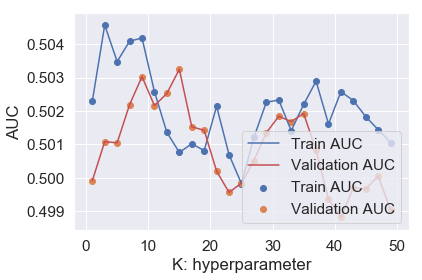

15


In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

X = sample['Cleaned_Text'].values
Y = sample['Score'].values
# split the data set into train and test
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X, Y, test_size=0.25)

count_vect = CountVectorizer() # converts text document into matrix token counts

X_train_bow = count_vect.fit_transform(X_train) #fitting and transforming the model
X_test_bow = count_vect.transform(X_test) 

print(X_train_bow.shape, y_train.shape)
print(X_test_bow.shape, y_test.shape)

# creating odd list of K for KNN
my_list = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, my_list))
auc_scores_train = []
auc_scores_cv = []

for k in tqdm(neighbors):
    # classifier with brute force method
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute') 
    # fitting the model
    knn.fit(X_train_bow, y_train_bow) 
    
    # obtaining AUC Values on train data with scoring parameter as roc_auc using cross_val_score
    scores = cross_val_score(knn, X_train_bow, y_train_bow, scoring='roc_auc') 
    auc_scores_train.append(scores.mean()) 
    # applying crossvalidation
    scores = cross_val_score(knn, X_train_bow, y_train_bow, cv=10, scoring='roc_auc') 
    auc_scores_cv.append(scores.mean()) 
        
print(auc_scores_train)
print(auc_scores_cv)

#Ploting AUC of Train and Test data
plt.plot(neighbors,auc_scores_train,'b',label='Train AUC')
plt.scatter(neighbors, auc_scores_train, label='Train AUC')
plt.plot(neighbors,auc_scores_cv,'r',label = 'Validation AUC')
plt.scatter(neighbors, auc_scores_cv, label='Validation AUC')
plt.legend(loc='lower right')
plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.grid(True)
plt.show()

print(neighbors[auc_scores_cv.index(max(auc_scores_cv))])

ROC AUC Curve


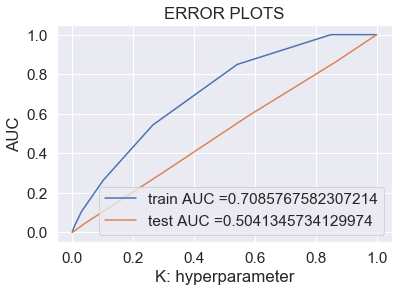

Accuracy on test data:0.85%
F1-Score on test data:0.00
Precision on test data:0.14
Recall on test data:0.00


In [70]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
#Testing AUC on Test data with best_k
best_k_bow = neighbors[auc_scores_cv.index(max(auc_scores_cv))]# Optimal k with maximum AUC Value

neigh = KNeighborsClassifier(n_neighbors=best_k_bow,algorithm='brute') # applying best k parameter on classifier
neigh.fit(X_train_bow, y_train_bow) #fitting the model

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
train_fpr, train_tpr, thresholds = roc_curve(y_train_bow, neigh.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test_bow, neigh.predict_proba(X_test_bow)[:,1])

# Plotting ROC AUC Curve
print("ROC AUC Curve")
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("Accuracy on test data:%0.2f%%"%(accuracy_score(y_test_bow,neigh.predict(X_test_bow)*100)))
print("F1-Score on test data:%0.2f"%(f1_score(y_test_bow,neigh.predict(X_test_bow))))
print("Precision on test data:%0.2f"%(precision_score(y_test_bow,neigh.predict(X_test_bow))))
print("Recall on test data:%0.2f"%(recall_score(y_test_bow,neigh.predict(X_test_bow))))

confusion matrix:
 [[TN FP]
 [FN TP] ]



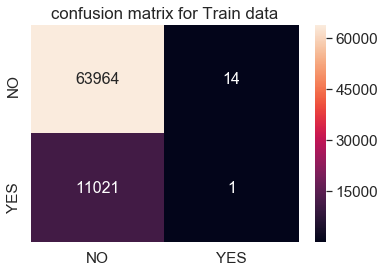

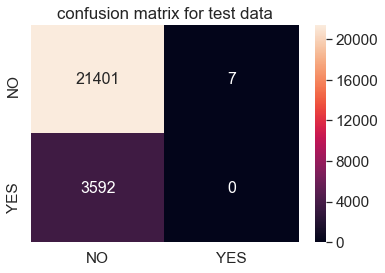

In [71]:
#Plotting Confusion matrix for Train and Test data 
print("confusion matrix:\n [[TN FP]\n [FN TP] ]\n")
classes = ['NO','YES']
plt.figure(1)
plt.title('confusion matrix for Train data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
df_cm = pd.DataFrame(confusion_matrix(y_train, neigh.predict(X_train_bow)),classes,classes)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size":16},fmt='g')

plt.figure(2)
plt.title('confusion matrix for test data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
df_cm1 = pd.DataFrame(confusion_matrix(y_test, neigh.predict(X_test_bow)),classes,classes)
sns.set(font_scale=1.4)
sns.heatmap(df_cm1, annot=True,annot_kws={"size":16},fmt='g')

## BOW GridSearchCv

Best Hyperparameter:  {'n_neighbors': 45}
Best AUC: 76.24%


ValueError: x and y must have same first dimension, but have shapes (1,) and (8,)

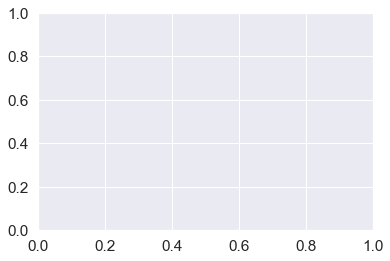

In [77]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV  #importing GridSearchCV from sklearn
from sklearn.model_selection import TimeSeriesSplit #importing TimeSeriesSplit from sklearn

X = sample['Cleaned_Text'].values
Y = sample['Score'].values
# split the data set into train and test
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X, Y, test_size=0.25,shuffle=False)#for time based splitting

count_vect = CountVectorizer() # converts text document into matrix token counts

X_train_bow = count_vect.fit_transform(X_train_bow) #fitting and transforming the model
X_test_bow = count_vect.transform(X_test_bow) 

neigh = KNeighborsClassifier(algorithm='brute')#instantiate Knn Model with brute force method
my_list = [1, 5, 10, 15, 21, 31, 41,45]
parameters = {'n_neighbors':my_list} # list of k neighbors
ts = TimeSeriesSplit(n_splits = 10) #using Time series split
Gscv_knn = GridSearchCV(neigh, parameters, cv=ts, scoring='roc_auc') #instantiate GridSearchCV with scoring parameter
                                                  # as roc_auc using TimeSeriesSplit
Gscv_knn.fit(X_train_bow, y_train_bow) #fitting the model

print("Best Hyperparameter: ",Gscv_knn.best_params_)
print("Best AUC: %.2f%%" %(Gscv_knn.best_score_*100))

Gscv_train_auc = Gscv_knn.cv_results_['mean_train_score']
Gscv_train_auc_std= Gscv_knn.cv_results_['std_train_score']
Gscv_cv_auc = Gscv_knn.cv_results_['mean_test_score']
Gscv_cv_auc_std = Gscv_knn.cv_results_['std_test_score']

plt.plot(parameters, Gscv_train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(my_list,Gscv_train_auc - Gscv_train_auc_std,Gscv_train_auc + Gscv_train_auc_std,alpha=0.2,color='darkblue')

plt.plot(my_list, Gscv_cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(my_list,Gscv_cv_auc - Gscv_cv_auc_std,Gscv_cv_auc + Gscv_cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [ ]:
#Testing AUC on Test data with best_k
best_k_bow_Gscv = list(Gscv_knn.best_params_.values())# Optimal k with maximum AUC Value

neigh = KNeighborsClassifier(n_neighbors=best_k_bow_Gscv,algorithm='brute') # applying best k parameter on classifier
neigh.fit(X_train_bow, y_train_bow) #fitting the model

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
train_fpr, train_tpr, thresholds = roc_curve(y_train_bow, neigh.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test_bow, neigh.predict_proba(X_test_bow)[:,1])

# Plotting ROC AUC Curve
print("ROC AUC Curve")
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("Accuracy on test data:%0.2f%%"%(accuracy_score(y_test_bow,neigh.predict(X_test_bow)*100)))
print("F1-Score on test data:%0.2f"%(fl_score(y_test_bow,neigh.predict(X_test_bow))))
print("Precision on test data:%0.2f"%(precision_score(y_test_bow,neigh.predict(X_test_bow))))
print("Recall on test data:%0.2f"%(recall_score(y_test_bow,neigh.predict(X_test_bow))))

In [ ]:
#Plotting Confusion matrix for Train and Test data 
print("confusion matrix:\n [[TN FP]\n [FN TP] ]\n")
classes = ['NO','YES']
plt.figure(1)
plt.title('confusion matrix for Train data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
df_cm = pd.DataFrame(confusion_matrix(y_train_bow, neigh.predict(X_train_bow)),classes,classes)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size":16},fmt='g')

plt.figure(2)
plt.title('confusion matrix for test data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
df_cm1 = pd.DataFrame(confusion_matrix(y_test_bow, neigh.predict(X_test_bow)),classes,classes)
sns.set(font_scale=1.4)
sns.heatmap(df_cm1, annot=True,annot_kws={"size":16},fmt='g')

### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

## TFIDF Kfold Cross validation

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

X = sample['Cleaned_Text'].values
Y = sample['Score'].values
# split the data set into train and test
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X, Y, test_size=0.25)

tfidf_vect = TfidfVectorizer()

X_train_tfidf = tfidf_vect.fit_transform(X_train_tfidf)
X_test_tfidf = tfidf_vect.transform(X_test_tfidf)

# creating odd list of K for KNN
neighbors = [1, 5, 10, 15, 21, 31, 41, 51]
auc_scores_train = []
auc_scores_cv = []

for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    knn.fit(X_train_tfidf, y_train)
    
    scores = cross_val_score(knn, X_train_tfidf, y_train, scoring='roc_auc')
    auc_scores_train.append(scores.mean())
    
    scores = cross_val_score(knn, X_train_tfidf, y_train, cv=10, scoring='roc_auc')
    auc_scores_cv.append(scores.mean())
        
print(auc_scores_train)
print(auc_scores_cv)

plt.plot(neighbors,auc_scores_train,'b',label='Train AUC')
plt.scatter(neighbors, auc_scores_train, label='Train AUC')
plt.plot(neighbors,auc_scores_cv,'r',label = 'Validation AUC')
plt.scatter(neighbors, auc_scores_cv, label='Validation AUC')
plt.legend(loc='lower right')
plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.grid(True)
plt.show()

print(neighbors[auc_scores_cv.index(max(auc_scores_cv))])


In [ ]:
# Determining Optimal k
best_k_Tfidf = neighbors[auc_scores_cv.index(max(auc_scores_cv))]
# Testing AUC on Test data with best_k 
Confusion_matrix_best_k(best_k_Tfidf,X_train_tfidf,X_test_tfidf,y_train_tfidf,y_test_tfidf)

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV  #importing GridSearchCV from sklearn
from sklearn.model_selection import TimeSeriesSplit #importing TimeSeriesSplit from sklearn

neigh = KNeighborsClassifier(algorithm='brute')#instantiate Knn Model with brute force method
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]} # list of k neighbors
ts = TimeSeriesSplit(n_splits = 10) #using Time series split
Gscv_knn = GridSearchCV(neigh, parameters, cv=ts, scoring='roc_auc') #instantiate GridSearchCV with scoring parameter
                                                  # as roc_auc using TimeSeriesSplit
Gscv_knn.fit(X_train_tfidf, y_train) #fitting the model

print("Best Hyperparameter: ",Gscv_knn.best_param_)
print("Best AUC: %.2f%%" %(Gscv_knn.best_score_*100))

Gscv_train_auc = Gscv_knn.cv_results_['mean_train_score']
Gscv_train_auc_std= Gscv_knn.cv_results_['std_train_score']
Gscv_cv_auc = Gscv_knn.cv_results_['mean_test_score']
Gscv_cv_auc_std = Gscv_knn.cv_results_['std_test_score']

plt.plot(parameters, Gscv_train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters,Gscv_train_auc - Gscv_train_auc_std,Gscv_train_auc + Gscv_train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters, Gscv_cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters,Gscv_cv_auc - Gscv_cv_auc_std,Gscv_cv_auc + Gscv_cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [ ]:
# Testing AUC on Test data with best_k 
best_k_tfidf_gscv = gscv.best_param_
Confusion_matrix_best_k(best_k_tfidf_gscv,X_train_tfidf,X_test_tfidf,y_train_tfidf,y_test_tfidf)

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

X = avg_w2v_vectors_norm
Y = sample['Score'].values
# split the data set into train and test
X_train_Avg_w2v, X_test_Avg_w2v, y_train_Avg_w2v, y_test_Avg_w2v = train_test_split(X, Y, test_size=0.25)

# creating odd list of K for KNN
neighbors = [1, 5, 10, 15, 21, 31, 41, 51]
auc_scores_train = []
auc_scores_cv = []

for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    knn.fit(X_train_Avg_w2v, y_train)
    
    scores = cross_val_score(knn, X_train_Avg_w2v, y_train, scoring='roc_auc')
    auc_scores_train.append(scores.mean())
    
    scores = cross_val_score(knn, X_train_Avg_w2v, y_train, cv=10, scoring='roc_auc')
    auc_scores_cv.append(scores.mean())
        
print(auc_scores_train)
print(auc_scores_cv)

plt.plot(neighbors,auc_scores_train,'b',label='Train AUC')
plt.scatter(neighbors, auc_scores_train, label='Train AUC')
plt.plot(neighbors,auc_scores_cv,'r',label = 'Validation AUC')
plt.scatter(neighbors, auc_scores_cv, label='Validation AUC')
plt.legend(loc='lower right')
plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.grid(True)
plt.show()

print(neighbors[auc_scores_cv.index(max(auc_scores_cv))])

In [ ]:
best_k_Avg_w2v = neighbors[auc_scores_cv.index(max(auc_scores_cv))]
Confusion_matrix_best_k(best_k_Avg_w2v,X_train_Avg_w2v,X_test_Avg_w2v,y_train_Avg_w2v,y_test_Avg_w2v)

## Avg_w2v GridSearchCV

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV  #importing GridSearchCV from sklearn
from sklearn.model_selection import TimeSeriesSplit #importing TimeSeriesSplit from sklearn

neigh = KNeighborsClassifier(algorithm='brute')#instantiate Knn Model with brute force method
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]} # list of k neighbors
ts = TimeSeriesSplit(n_splits = 10) #using Time series split
Gscv_knn = GridSearchCV(neigh, parameters, cv=ts, scoring='roc_auc') #instantiate GridSearchCV with scoring parameter
                                                  # as roc_auc using TimeSeriesSplit
Gscv_knn.fit(X_train_Avg_w2v, y_train) #fitting the model

print("Best Hyperparameter: ",Gscv_knn.best_param_)
print("Best AUC: %.2f%%" %(Gscv_knn.best_score_*100))

Gscv_train_auc = Gscv_knn.cv_results_['mean_train_score']
Gscv_train_auc_std= Gscv_knn.cv_results_['std_train_score']
Gscv_cv_auc = Gscv_knn.cv_results_['mean_test_score']
Gscv_cv_auc_std = Gscv_knn.cv_results_['std_test_score']

plt.plot(parameters, Gscv_train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters,Gscv_train_auc - Gscv_train_auc_std,Gscv_train_auc + Gscv_train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters, Gscv_cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters,Gscv_cv_auc - Gscv_cv_auc_std,Gscv_cv_auc + Gscv_cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [ ]:
best_k_Avg_w2v_gscv = neighbors[auc_scores_cv.index(max(auc_scores_cv))]
Confusion_matrix_best_k(best_k_Avg_w2v_gscv,X_train_Avg_w2v,X_test_Avg_w2v,y_train_Avg_w2v,y_test_Avg_w2v)

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

tfidf_sent_vectors_norm = preprocessing.normalize(tfidf_sent_vectors)
X = tfidf_sent_vectors_norm
Y = sample['Score'].values
# split the data set into train and test
X_train_Tfidf_w2v, X_test_Tfidf_w2v, y_train_Tfidf_w2v, y_test_Tfidf_w2v = train_test_split(X, Y, test_size=0.25)

# creating odd list of K for KNN
neighbors = [1, 5, 10, 15, 21, 31, 41, 51]
auc_scores_train = []
auc_scores_cv = []

for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    knn.fit(X_train_Tfidf_w2v, y_train_Tfidf_w2v)
    
    scores = cross_val_score(knn, X_train_Tfidf_w2v, y_train_Tfidf_w2v, scoring='roc_auc')
    auc_scores_train.append(scores.mean())
    
    scores = cross_val_score(knn, X_train_Tfidf_w2v, y_train_Tfidf_w2v, cv=10, scoring='roc_auc')
    auc_scores_cv.append(scores.mean())
        
print(auc_scores_train)
print(auc_scores_cv)

plt.plot(neighbors,auc_scores_train,'b',label='Train AUC')
plt.scatter(neighbors, auc_scores_train, label='Train AUC')
plt.plot(neighbors,auc_scores_cv,'r',label = 'Validation AUC')
plt.scatter(neighbors, auc_scores_cv, label='Validation AUC')
plt.legend(loc='lower right')
plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.grid(True)
plt.show()

print(neighbors[auc_scores_cv.index(max(auc_scores_cv))])


In [ ]:
best_k_Tfidf_w2v = neighbors[auc_scores_cv.index(max(auc_scores_cv))]
Confusion_matrix_best_k(best_k_Tfidf_w2v,X_train_Tfidf_w2v,X_test_Tfidf_w2v,y_train_Tfidf_w2v, y_test_Tfidf_w2v)

## TFIDF W2V GridSearchCV

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV  #importing GridSearchCV from sklearn
from sklearn.model_selection import TimeSeriesSplit #importing TimeSeriesSplit from sklearn

neigh = KNeighborsClassifier(algorithm='brute')#instantiate Knn Model with brute force method
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]} # list of k neighbors
ts = TimeSeriesSplit(n_splits = 10) #using Time series split
Gscv_knn = GridSearchCV(neigh, parameters, cv=ts, scoring='roc_auc') #instantiate GridSearchCV with scoring parameter
                                                  # as roc_auc using TimeSeriesSplit
Gscv_knn.fit(X_train_Tfidf_w2v, y_train_Tfidf_w2v) #fitting the model

print("Best Hyperparameter: ",Gscv_knn.best_param_)
print("Best AUC: %.2f%%" %(Gscv_knn.best_score_*100))

Gscv_train_auc = Gscv_knn.cv_results_['mean_train_score']
Gscv_train_auc_std= Gscv_knn.cv_results_['std_train_score']
Gscv_cv_auc = Gscv_knn.cv_results_['mean_test_score']
Gscv_cv_auc_std = Gscv_knn.cv_results_['std_test_score']

plt.plot(parameters, Gscv_train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters,Gscv_train_auc - Gscv_train_auc_std,Gscv_train_auc + Gscv_train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters, Gscv_cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters,Gscv_cv_auc - Gscv_cv_auc_std,Gscv_cv_auc + Gscv_cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [ ]:
best_k_Tfidf_w2v_gscv = neighbors[auc_scores_cv.index(max(auc_scores_cv))]
Confusion_matrix_best_k(best_k_Tfidf_w2v_gscv,X_train_Tfidf_w2v,X_test_Tfidf_w2v,y_train_Tfidf_w2v, y_test_Tfidf_w2v)

## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [ ]:
# Taking 100000 reviews for analysis
n_samples = 25000
final_sample = final.sample(n_samples)

final_sample.head(5)

In [ ]:
# Save to file
pickle.dump(final_sample,open("sample_25000_knn.pkl","wb"))

# Load from file
sample1 = pickle.load(open("sample_25000_knn.pkl","rb"))

In [ ]:
def Confusion_matrix_best_k_kdtree(best_k,X_train,X_test,y_train,y_test):
        
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
    from sklearn.metrics import roc_curve, auc
    
    neigh = KNeighborsClassifier(n_neighbors=best_k,algorithm='kd_tree') # applying best k parameter on classifier
    neigh.fit(X_train, y_train) #fitting the model
    
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test)[:,1])
    
    # ploting ROC AUC Curve
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("K: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()
    
    print("="*100)
    
    from sklearn.metrics import confusion_matrix
    print("Train confusion matrix")
    print(confusion_matrix(y_train, neigh.predict(X_train))) 
    print("Test confusion matrix")
    print(confusion_matrix(y_test, neigh.predict(X_test)))
    
    #Ploting Confusion matrix for Train and Test data 
    classes = ['NO','YES']
    plt.figure(1)
    plt.title('confusion matrix for Train data')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    df_cm = pd.DataFrame(confusion_matrix(y_train, neigh.predict(X_train)),classes,classes)
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True,annot_kws={"size":16},fmt='g')
    
    plt.figure(2)
    plt.title('confusion matrix for test data')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    df_cm1 = pd.DataFrame(confusion_matrix(y_test, neigh.predict(X_test)),classes,classes)
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm1, annot=True,annot_kws={"size":16},fmt='g')

## BOW Kd Tree Kfold Cross validation

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

X = sample1['Cleaned_Text'].values
Y = sample1['Score'].values
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

count_vect = CountVectorizer(min_df=10, max_features=500)

X_train_bow = count_vect.fit_transform(X_train)
X_test_bow = count_vect.transform(X_test)

# creating odd list of K for KNN
neighbors = [1, 5, 10, 15, 21, 31, 41, 51]
auc_scores_train = []
auc_scores_cv = []

for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    knn.fit(X_train_bow, y_train)
    
    scores = cross_val_score(knn, X_train_bow, y_train, cv=10, scoring='roc_auc')
    auc_scores_cv.append(scores.mean())
        
print(auc_scores_train)
print(auc_scores_cv)

plt.plot(neighbors,auc_scores_train,'b',label='Train AUC')
plt.scatter(neighbors, auc_scores_train, label='Train AUC')
plt.plot(neighbors,auc_scores_cv,'r',label = 'Validation AUC')
plt.scatter(neighbors, auc_scores_cv, label='Validation AUC')
plt.legend(loc='lower right')
plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.grid(True)
plt.show()

print(neighbors[auc_scores_cv.index(max(auc_scores_cv))])


In [ ]:
#Testing AUC on Test data with best_k
best_k_bow_kdtree = neighbors[auc_scores_cv.index(max(auc_scores_cv))]# Optimal k with maximum AUC Value
Confusion_matrix_best_k_kdtree(best_k_bow_kdtree,X_train_bow,X_test_bow,y_train,y_test)

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV  #importing GridSearchCV from sklearn
from sklearn.model_selection import TimeSeriesSplit #importing TimeSeriesSplit from sklearn

neigh = KNeighborsClassifier(algorithm='kd_tree')#instantiate Knn Model with brute force method
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]} # list of k neighbors
ts = TimeSeriesSplit(n_splits = 10) #using Time series split
Gscv_knn = GridSearchCV(neigh, parameters, cv=ts, scoring='roc_auc') #instantiate GridSearchCV with scoring parameter
                                                  # as roc_auc using TimeSeriesSplit
Gscv_knn.fit(X_train_bow, y_train) #fitting the model

print("Best Hyperparameter: ",Gscv_knn.best_param_)
print("Best AUC: %.2f%%" %(Gscv_knn.best_score_*100))

Gscv_train_auc = Gscv_knn.cv_results_['mean_train_score']
Gscv_train_auc_std= Gscv_knn.cv_results_['std_train_score']
Gscv_cv_auc = Gscv_knn.cv_results_['mean_test_score']
Gscv_cv_auc_std = Gscv_knn.cv_results_['std_test_score']

plt.plot(parameters, Gscv_train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters,Gscv_train_auc - Gscv_train_auc_std,Gscv_train_auc + Gscv_train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters, Gscv_cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters,Gscv_cv_auc - Gscv_cv_auc_std,Gscv_cv_auc + Gscv_cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [ ]:
# Testing AUC on Test data with best_k 
best_k_bow_kdtree_gscv = gscv.best_param_
Confusion_matrix_best_k_kdtree(best_k_bow_kdtree_gscv,X_train_bow,X_test_bow,y_train,y_test)

### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

X = sample1['Cleaned_Text'].values
Y = sample1['Score'].values
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

tfidf_vect = TfidfVectorizer(min_df=10, max_features=500)

X_train_tfidf = tfidf_vect.fit_transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)

X_train_tfidf = X_train_tfidf.toarray()
# creating odd list of K for KNN
neighbors = [1, 5, 10, 15, 21, 31, 41, 51]
auc_scores_train = []
auc_scores_cv = []

for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    knn.fit(X_train_tfidf, y_train)
    
    scores = cross_val_score(knn, X_train_tfidf, y_train, scoring='roc_auc')
    auc_scores_train.append(scores.mean())
    
    scores = cross_val_score(knn, X_train_tfidf, y_train, cv=10, scoring='roc_auc')
    auc_scores_cv.append(scores.mean())
        
print(auc_scores_train)
print(auc_scores_cv)

plt.plot(neighbors,auc_scores_train,'b',label='Train AUC')
plt.scatter(neighbors, auc_scores_train, label='Train AUC')
plt.plot(neighbors,auc_scores_cv,'r',label = 'Validation AUC')
plt.scatter(neighbors, auc_scores_cv, label='Validation AUC')
plt.legend(loc='lower right')
plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.grid(True)
plt.show()

print(neighbors[auc_scores_cv.index(max(auc_scores_cv))])

In [ ]:
# Determining Optimal k
best_k_Tfidf_kdtree = neighbors[auc_scores_cv.index(max(auc_scores_cv))]
# Testing AUC on Test data with best_k 
Confusion_matrix_best_k_kdtree(best_k_Tfidf_kdtree,X_train_tfidf,X_test_tfidf,y_train_tfidf,y_test_tfidf)

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV  #importing GridSearchCV from sklearn
from sklearn.model_selection import TimeSeriesSplit #importing TimeSeriesSplit from sklearn

neigh = KNeighborsClassifier(algorithm='kd_tree')#instantiate Knn Model with brute force method
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]} # list of k neighbors
ts = TimeSeriesSplit(n_splits = 10) #using Time series split
Gscv_knn = GridSearchCV(neigh, parameters, cv=ts, scoring='roc_auc') #instantiate GridSearchCV with scoring parameter
                                                  # as roc_auc using TimeSeriesSplit
Gscv_knn.fit(X_train_tfidf, y_train) #fitting the model

print("Best Hyperparameter: ",Gscv_knn.best_param_)
print("Best AUC: %.2f%%" %(Gscv_knn.best_score_*100))

Gscv_train_auc = Gscv_knn.cv_results_['mean_train_score']
Gscv_train_auc_std= Gscv_knn.cv_results_['std_train_score']
Gscv_cv_auc = Gscv_knn.cv_results_['mean_test_score']
Gscv_cv_auc_std = Gscv_knn.cv_results_['std_test_score']

plt.plot(parameters, Gscv_train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters,Gscv_train_auc - Gscv_train_auc_std,Gscv_train_auc + Gscv_train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters, Gscv_cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters,Gscv_cv_auc - Gscv_cv_auc_std,Gscv_cv_auc + Gscv_cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [ ]:
# Testing AUC on Test data with best_k 
best_k_tfidf_kdtree_gscv = gscv.best_param_
Confusion_matrix_best_k_kdtree(best_k_tfidf_kdtree_gscv,X_train_tfidf,X_test_tfidf,y_train_tfidf,y_test_tfidf)

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

## Kfold Cross validation kd-tree on AVG W2V

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

X = avg_w2v_vectors
Y = sample1['Score'].values
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

Avg_w2v_vect = TfidfVectorizer()

X_train_Avg_w2v = Avg_w2v_vect.fit_transform(X_train)
X_test_Avg_w2v = Avg_w2v_vect.transform(X_test)

# creating odd list of K for KNN
neighbors = [1, 5, 10, 15, 21, 31, 41, 51]
auc_scores_train = []
auc_scores_cv = []

for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    knn.fit(X_train_Avg_w2v, y_train)
    
    scores = cross_val_score(knn, X_train_Avg_w2v, y_train, scoring='roc_auc')
    auc_scores_train.append(scores.mean())
    
    scores = cross_val_score(knn, X_train_Avg_w2v, y_train, cv=10, scoring='roc_auc')
    auc_scores_cv.append(scores.mean())
        
print(auc_scores_train)
print(auc_scores_cv)

plt.plot(neighbors,auc_scores_train,'b',label='Train AUC')
plt.scatter(neighbors, auc_scores_train, label='Train AUC')
plt.plot(neighbors,auc_scores_cv,'r',label = 'Validation AUC')
plt.scatter(neighbors, auc_scores_cv, label='Validation AUC')
plt.legend(loc='lower right')
plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.grid(True)
plt.show()

print(neighbors[auc_scores_cv.index(max(auc_scores_cv))])

In [ ]:
best_k_Avg_w2v_kdtree = neighbors[auc_scores_cv.index(max(auc_scores_cv))]
Confusion_matrix_best_k_kdtree(best_k_Avg_w2v_kdtree,X_train_Avg_w2v,X_test_Avg_w2v,y_train_Avg_w2v,y_test_Avg_w2v)

## GridSearchCV kd-tree on AVG W2V 

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV  #importing GridSearchCV from sklearn
from sklearn.model_selection import TimeSeriesSplit #importing TimeSeriesSplit from sklearn

neigh = KNeighborsClassifier(algorithm='kd_tree')#instantiate Knn Model with brute force method
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]} # list of k neighbors
ts = TimeSeriesSplit(n_splits = 10) #using Time series split
Gscv_knn = GridSearchCV(neigh, parameters, cv=ts, scoring='roc_auc') #instantiate GridSearchCV with scoring parameter
                                                  # as roc_auc using TimeSeriesSplit
Gscv_knn.fit(X_train_Avg_w2v, y_train) #fitting the model

print("Best Hyperparameter: ",Gscv_knn.best_param_)
print("Best AUC: %.2f%%" %(Gscv_knn.best_score_*100))

Gscv_train_auc = Gscv_knn.cv_results_['mean_train_score']
Gscv_train_auc_std= Gscv_knn.cv_results_['std_train_score']
Gscv_cv_auc = Gscv_knn.cv_results_['mean_test_score']
Gscv_cv_auc_std = Gscv_knn.cv_results_['std_test_score']

plt.plot(parameters, Gscv_train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters,Gscv_train_auc - Gscv_train_auc_std,Gscv_train_auc + Gscv_train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters, Gscv_cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters,Gscv_cv_auc - Gscv_cv_auc_std,Gscv_cv_auc + Gscv_cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [ ]:
best_k_Avg_w2v_kdtree_gscv = neighbors[auc_scores_cv.index(max(auc_scores_cv))]
Confusion_matrix_best_k_kdtree(best_k_Avg_w2v_kdtree_gscv,X_train_Avg_w2v,X_test_Avg_w2v,y_train_Avg_w2v,y_test_Avg_w2v)

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

## Kfold Cross validation kd-tree TFIDF W2V

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

X = tfidf_sent_vectors
Y = sample['Score'].values
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

X_train_Tfidf_w2v = Tfidf_w2v_vect.fit_transform(X_train)
X_test_Tfidf_w2v = Tfidf_w2v_vect.transform(X_test)


# creating odd list of K for KNN
neighbors = [1, 5, 10, 15, 21, 31, 41, 51]
auc_scores_train = []
auc_scores_cv = []

for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    knn.fit(X_train_Tfidf_w2v, y_train)
    
    scores = cross_val_score(knn, X_train_Tfidf_w2v, y_train, scoring='roc_auc')
    auc_scores_train.append(scores.mean())
    
    scores = cross_val_score(knn, X_train_Tfidf_w2v, y_train, cv=10, scoring='roc_auc')
    auc_scores_cv.append(scores.mean())
        
print(auc_scores_train)
print(auc_scores_cv)

plt.plot(neighbors,auc_scores_train,'b',label='Train AUC')
plt.scatter(neighbors, auc_scores_train, label='Train AUC')
plt.plot(neighbors,auc_scores_cv,'r',label = 'Validation AUC')
plt.scatter(neighbors, auc_scores_cv, label='Validation AUC')
plt.legend(loc='lower right')
plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.grid(True)
plt.show()

print(neighbors[auc_scores_cv.index(max(auc_scores_cv))])
best_k = neighbors[auc_scores_cv.index(max(auc_scores_cv))]


In [ ]:
best_k_Tfidf_w2v_kdtree = neighbors[auc_scores_cv.index(max(auc_scores_cv))]
Confusion_matrix_best_k_kdtree(best_k_Tfidf_w2v_kdtree,X_train_Tfidf_w2v,X_test_Tfidf_w2v,y_train_Tfidf_w2v, y_test_Tfidf_w2v)

## GridSearchCV kd-tree TFIDF W2V

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV  #importing GridSearchCV from sklearn
from sklearn.model_selection import TimeSeriesSplit #importing TimeSeriesSplit from sklearn

neigh = KNeighborsClassifier(algorithm='kd_tree')#instantiate Knn Model with brute force method
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]} # list of k neighbors
ts = TimeSeriesSplit(n_splits = 10) #using Time series split
Gscv_knn = GridSearchCV(neigh, parameters, cv=ts, scoring='roc_auc') #instantiate GridSearchCV with scoring parameter
                                                  # as roc_auc using TimeSeriesSplit
Gscv_knn.fit(X_train_Tfidf_w2v, y_train_Tfidf_w2v) #fitting the model

print("Best Hyperparameter: ",Gscv_knn.best_param_)
print("Best AUC: %.2f%%" %(Gscv_knn.best_score_*100))

Gscv_train_auc = Gscv_knn.cv_results_['mean_train_score']
Gscv_train_auc_std= Gscv_knn.cv_results_['std_train_score']
Gscv_cv_auc = Gscv_knn.cv_results_['mean_test_score']
Gscv_cv_auc_std = Gscv_knn.cv_results_['std_test_score']

plt.plot(parameters, Gscv_train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters,Gscv_train_auc - Gscv_train_auc_std,Gscv_train_auc + Gscv_train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters, Gscv_cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters,Gscv_cv_auc - Gscv_cv_auc_std,Gscv_cv_auc + Gscv_cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [ ]:
best_k_Tfidf_w2v_kdtree_gscv = neighbors[auc_scores_cv.index(max(auc_scores_cv))]
Confusion_matrix_best_k_kdtree(best_k_Tfidf_w2v_kdtree_gscv,X_train_Tfidf_w2v,X_test_Tfidf_w2v,y_train_Tfidf_w2v, y_test_Tfidf_w2v)

# [6] Conclusions

In [ ]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Hyper Parameters/KFOLD","Hyper Parameters/GridSearch","Accuracy","AUC"]

x.add_row(["BOW","Brute",best_k_bow,best_k_bow_gscv,])
x.add_row(["TFIDF","Brute",best_k_Tfidf,best_k_tfidf_gscv,84.04,0.81])
x.add_row(["AVG_W2V","Brute",best_k_Avg_w2v,best_k_Avg_w2v,85.74,0.77])
x.add_row(["TFIDF_W2V", "Brute",best_k_Tfidf_w2v,best_k_Tfidf_w2v_gscv,85.05,0.75])

x.add_row(["BOW","kd_tree",best_k_bow_kdtree,best_k_bow_kdtree_gscv,85.74,0.77])
x.add_row(["TFIDF","kd_tree",best_k_Tfidf_kdtree,best_k_tfidf_kdtree_gscv,84.07,0.77])
x.add_row(["AVG_W2V","kd_tree",best_k_Avg_w2v_kdtree,best_k_Avg_w2v_kdtree_gscv,85.36,0.77])
x.add_row(["TFIDF_W2V", "kd_tree",best_k_Tfidf_w2v_kdtree,best_k_Tfidf_w2v_kdtree_gscv,84.80,0.74])


print(x)
